In [2]:
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T

hr_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/jenny_256_256/hr'
lr_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/jenny_256_256/lr'
hiseq_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/jenny_256_256/hiseq'

hr_files = [p for p in Path('{}'.format(hr_path)).glob(f'**/*')]
# hr_files=sorted(hr_files, key=lambda i: int(i.stem))

lr_files = [p for p in Path('{}'.format(lr_path)).glob(f'**/*')]
# lr_files=sorted(lr_files, key=lambda i: int(i.stem))

hiseq_files = [p for p in Path('{}'.format(hiseq_path)).glob(f'**/*')]
# hiseq_files=sorted(hiseq_files, key=lambda i: int(i.stem))

In [3]:
mean_hr = [0.07257154583930969, 0.08836060762405396, 0.08394594490528107]
std_hr = [0.07227534055709839, 0.07447945326566696, 0.07821875810623169] 

mean_lr = [0.07257154583930969, 0.08836060762405396, 0.08394594490528107] 
std_lr = [0.07227534055709839, 0.07447945326566696, 0.07821875810623169] 

mean_hiseq = [0.48544687032699585, 0.4815044701099396, 0.4845569431781769]  
std_hiseq = [0.2915918231010437, 0.2814886271953583, 0.2883751392364502]  

transform_hr = T.Compose([
    T.ToTensor(),
    T.Normalize(mean_hr, std_hr)
])

transform_lr = T.Compose([
    T.ToTensor(),
    T.Normalize(mean_lr, std_lr)
])

transform_hiseq = T.Compose([
    T.ToTensor(),
    T.Normalize(mean_hiseq, std_hiseq)
])

In [4]:
def to_tensor_and_normalize(files, mode='LR'):
    img_ls = []

    for file in tqdm(files):
        img = Image.open(file).convert('RGB')
        if mode == 'HR':
            img = transform_hr(img)
        elif mode == 'LR':
            img = transform_lr(img)
        else:
            img = transform_hiseq(img)
        img_ls.append(img)
    
    img_ls = torch.stack(img_ls, 0)

    return img_ls

In [5]:
hr_imgs = to_tensor_and_normalize(hr_files, 'HR')
lr_imgs = to_tensor_and_normalize(lr_files, 'LR')
hiseq_imgs = to_tensor_and_normalize(hiseq_files, 'Hiseq')

100%|██████████| 175/175 [00:00<00:00, 208.31it/s]


In [6]:
def find_y_avg(imgs):
    y_list = []
    
    for i in tqdm(range(imgs.shape[0])):
        y = 0.299*imgs[i,0,:,:] + 0.587*imgs[i,1,:,:] + 0.114*imgs[i,2,:,:]
        y_avg = np.average(y)
        y_list.append(y_avg)
    
    return np.array(y_list)

In [7]:
def calculate_mean_std(imgs):

    mean_ls = []
    std_ls = []
    
    channels = imgs.shape[1]

    for i in tqdm(range(channels)):
        all_pixels = imgs[:,i,:,:]
        
        std, mean = torch.std_mean(all_pixels)

        mean_ls.append(mean.item())
        std_ls.append(std.item())
    
    return mean_ls, std_ls
    

In [8]:
mean_hr, std_hr = calculate_mean_std(hr_imgs)
print(mean_hr)
print(std_hr)

mean_lr, std_lr = calculate_mean_std(lr_imgs)
print(mean_lr)
print(std_lr)

mean_hiseq, std_hiseq = calculate_mean_std(hiseq_imgs)
print(mean_hiseq)
print(std_hiseq)

100%|██████████| 3/3 [00:00<00:00, 128.16it/s]


[2.839705537382997e-08, -4.2892306595376795e-08, -4.557692179218975e-08]
[1.0, 1.0, 0.9999999403953552]


100%|██████████| 3/3 [00:00<00:00, 169.75it/s]


[2.839705537382997e-08, -4.2892306595376795e-08, -4.557692179218975e-08]
[1.0, 1.0, 0.9999999403953552]


100%|██████████| 3/3 [00:00<00:00, 174.67it/s]

[3.006065441013561e-08, -4.5494900291487284e-08, 4.867809977326942e-08]
[1.0, 0.9999999403953552, 1.0]


In [9]:
hr_y = find_y_avg(hr_imgs)
lr_y = find_y_avg(lr_imgs)
hiseq_y = find_y_avg(hiseq_imgs)

100%|██████████| 175/175 [00:00<00:00, 3387.50it/s]


In [11]:
hr_sample = hr_imgs[0].permute(1,2,0).numpy()/2 + 0.5
lr_sample = lr_imgs[0].permute(1,2,0).numpy()/2 + 0.5
hiseq_sample = hiseq_imgs[0].permute(1,2,0).numpy()/2 + 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


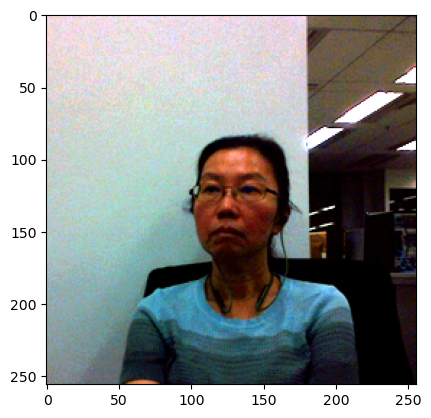

In [12]:
plt.imshow(hr_sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


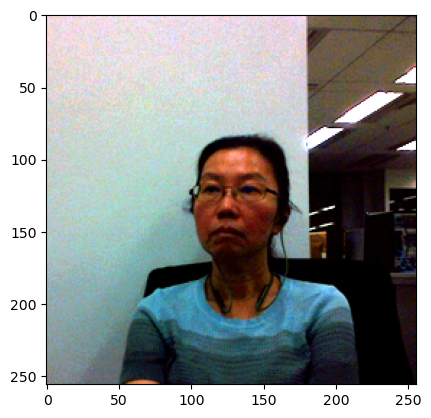

In [13]:
plt.imshow(lr_sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


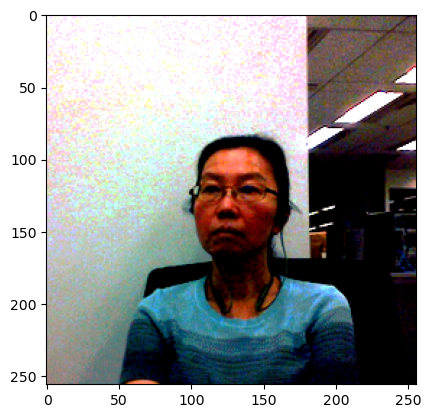

In [14]:
plt.imshow(hiseq_sample)

Text(0.5, 1.0, 'Y distribution of HR-norm imgs')

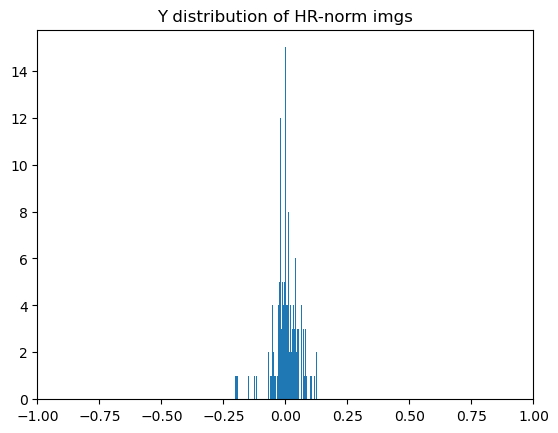

In [15]:
plt.hist(hr_y, bins=100)
plt.xlim(-1, 1)
plt.title('Y distribution of HR-norm imgs')


Text(0.5, 1.0, 'Y distribution of LR-norm imgs')

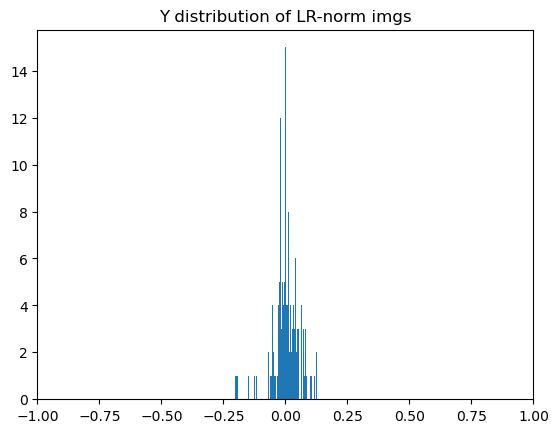

In [16]:
plt.hist(lr_y, bins=100)
plt.xlim(-1, 1)
plt.title('Y distribution of LR-norm imgs')

Text(0.5, 1.0, 'Y distribution of Hiseq-norm imgs')

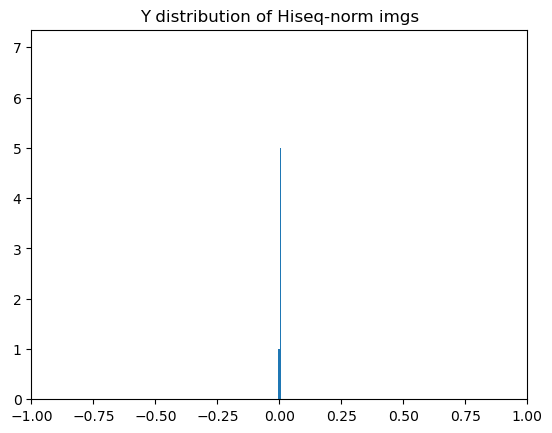

In [17]:
plt.hist(hiseq_y, bins=100)
plt.xlim(-1, 1)
plt.title('Y distribution of Hiseq-norm imgs')